In [1]:
import pyproj
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.ops import nearest_points
from shapely.geometry import Point
import osmnx as ox

In [2]:
# Minimale und maximale Breite und Länge des Rechtecks
north, south, east, west = 47.3667, 47.2586, 8.754, 8.6103

# Herunterladen des Straßennetzwerks basierend auf dem Rechteck
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

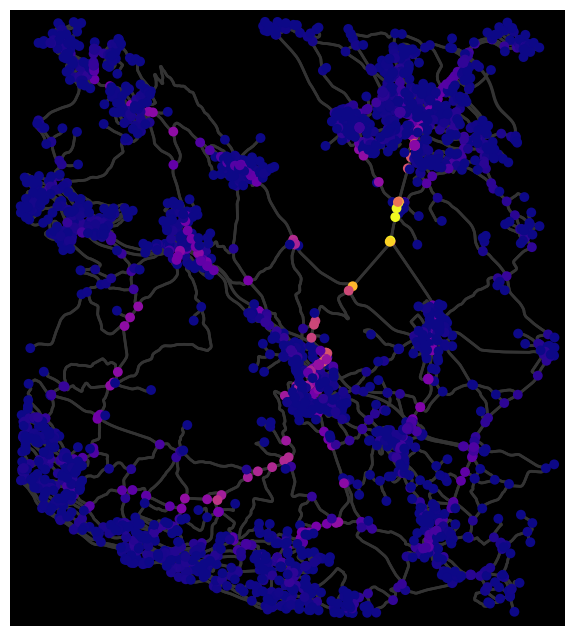

In [3]:
# impute edge (driving) speeds and calculate edge travel times
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
G = ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333")

In [4]:
ROOT_FILES = 'C:/Users/Linus/PycharmProjects/BA/'
ROOT_Busstations = 'src/main/resources/Buslinie/Busstationen/'

#Pfad zur Shapefile-Datei mit den Strassen
ROOT_RESOURCE_STRASSENNETZ = 'src/main/resources/QGIS/Strassen/'
#DATEN_STRASSENNETZ = gpd.read_file(ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + 'Tramstrasse.shp')

# save graph as a geopackage or graphml file
ox.io.save_graph_geopackage(G, filepath = ROOT_FILES + ROOT_RESOURCE_STRASSENNETZ + "./OSMStrassennetz.gpkg")

# Pfad zur Shapefile-Datei mit den Bushaltestellen
shapefile_path = ROOT_FILES + ROOT_Busstations + "Bushalte.shp"

# Laden der Bushaltestellen als GeoDataFrame
bus_stops = gpd.read_file(shapefile_path)

import geopandas as gpd

def add_return_trip(bus_stops):
    # Kopiere das GeoDataFrame, um die Rückfahrt-Haltestellen hinzuzufügen
    return_trip_stops = bus_stops.copy()

    # Entferne die Haltestelle mit der niedrigsten und höchsten ID
    return_trip_stops = return_trip_stops.iloc[:-1]

    # Kehre die Reihenfolge der Haltestellen um
    return_trip_stops = return_trip_stops.iloc[::-1]

    # Füge die Rückfahrt-Haltestellen hinzu
    bus_stops_with_return = pd.concat([bus_stops, return_trip_stops], ignore_index=True)
    
    return bus_stops_with_return

# Beispielaufruf
bus_stops_with_return = add_return_trip(bus_stops)


print(bus_stops_with_return)

    id                         name                         geometry
0    1              Meilen, Bahnhof  POINT (2691216.442 1236097.130)
1    2               Meilen, Beugen  POINT (2691721.577 1235859.957)
2    3            Meilen, Schulhaus  POINT (2692164.131 1235952.189)
3    4             Meilen, Aebleten  POINT (2692625.713 1236089.963)
4    5     Uetikon am See, Rundiweg  POINT (2693795.522 1236390.838)
5    6     Uetikon am See, Bergheim  POINT (2694359.533 1236444.631)
6    7         Egg, Ausser-Vollikon  POINT (2695191.913 1237693.175)
7    8          Egg, Inner-Vollikon  POINT (2694957.869 1238374.380)
8    9             Egg, Rainstrasse  POINT (2694619.737 1239083.099)
9   10               Egg, Forchbahn  POINT (2694600.924 1239702.345)
10  11               Egg, Industrie  POINT (2694763.351 1240053.164)
11  12  Riedikon, Chis/Naturstation  POINT (2696074.245 1242503.350)
12  13               Riedikon, Dorf  POINT (2696196.601 1243162.888)
13  14             Uster, Im Hölzl

In [5]:
# LV95 Projektionsdefinition
lv95 = pyproj.Proj(init='epsg:2056')

# WGS 84 Projektionsdefinition
wgs84 = pyproj.Proj(init='epsg:4326')

# Funktion zur Umwandlung von LV95 nach WGS 84
def lv95_to_wgs84(point):
    x_lv95, y_lv95 = point.x, point.y
    x_wgs84, y_wgs84 = pyproj.transform(lv95, wgs84, x_lv95, y_lv95)
    return Point(x_wgs84, y_wgs84)

# Beispiel GeoDataFrame
# Annahme: MeinGDF ist Ihr GeoDataFrame
# Annahme: Die Geometrie ist vom Typ Point
bus_stops_with_return['geometry'] = bus_stops_with_return['geometry'].apply(lv95_to_wgs84)

# Ergebnis: MeinGDF enthält nun die Geometrien im WGS 84 Format
print(bus_stops_with_return)


c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\Linus\anaconda3\envs\gta23v2\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Linus\AppData\Local\Temp\ipykernel_9784\3700713179.py:10: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-fro

    id                         name              geometry
0    1              Meilen, Bahnhof  POINT (8.644 47.269)
1    2               Meilen, Beugen  POINT (8.651 47.267)
2    3            Meilen, Schulhaus  POINT (8.657 47.268)
3    4             Meilen, Aebleten  POINT (8.663 47.269)
4    5     Uetikon am See, Rundiweg  POINT (8.678 47.272)
5    6     Uetikon am See, Bergheim  POINT (8.686 47.272)
6    7         Egg, Ausser-Vollikon  POINT (8.697 47.283)
7    8          Egg, Inner-Vollikon  POINT (8.694 47.289)
8    9             Egg, Rainstrasse  POINT (8.690 47.296)
9   10               Egg, Forchbahn  POINT (8.690 47.301)
10  11               Egg, Industrie  POINT (8.692 47.305)
11  12  Riedikon, Chis/Naturstation  POINT (8.710 47.326)
12  13               Riedikon, Dorf  POINT (8.711 47.332)
13  14             Uster, Im Hölzli  POINT (8.714 47.339)
14  15              Uster, Talacker  POINT (8.716 47.343)
15  16        Uster, Zentralstrasse  POINT (8.718 47.347)
16  17        

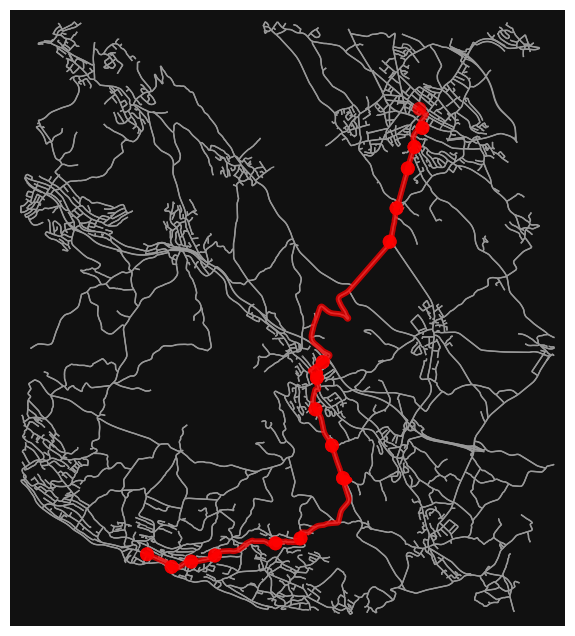

In [6]:
# Annahme: G ist Ihr Graph mit dem Straßennetzwerk
# Annahme: points_gdf ist Ihr GeoDataFrame mit den Punkten

# Definieren Sie eine Funktion, um die nächsten Netzwerkknoten zu einem Punkt zu finden
def get_nearest_node(G, point):
    nearest_node = ox.distance.nearest_nodes(G, point.x, point.y)
    return nearest_node

# Lesen Sie das GeoDataFrame ein
points_gdf = bus_stops_with_return

# Erstellen Sie eine leere Liste, um die Routen zu speichern
routes = []

# Iterieren Sie durch das GeoDataFrame und finden Sie für jeden Punkt den kürzesten Pfad
for idx, row in points_gdf.iterrows():
    orig = get_nearest_node(G, row['geometry'])
    # Hier suchen wir den nächsten Punkt zum aktuellen Punkt
    next_row = points_gdf.iloc[(idx + 1) % len(points_gdf)]
    dest = get_nearest_node(G, next_row['geometry'])
    route = ox.shortest_path(G, orig, dest, weight="travel_time")
    routes.append(route)

# Plotten Sie alle Routen
fig, ax = ox.plot_graph_routes(G, routes, node_size=0)


In [7]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 2492,
 'm': 5864,
 'k_avg': 4.706260032102729,
 'edge_length_total': 1022684.841000001,
 'edge_length_avg': 174.4005526944067,
 'streets_per_node_avg': 2.5425361155698236,
 'streets_per_node_counts': {0: 0, 1: 635, 2: 20, 3: 1692, 4: 140, 5: 5},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.25481540930979135,
  2: 0.008025682182985553,
  3: 0.6789727126805778,
  4: 0.056179775280898875,
  5: 0.0020064205457463883},
 'intersection_count': 1857,
 'street_length_total': 535942.4180000015,
 'street_segment_count': 3132,
 'street_length_avg': 171.11826883780378,
 'circuity_avg': 1.0877899192618126,
 'self_loop_proportion': 0.00351213282247765,
 'clean_intersection_count': 1439,
 'node_density_km': 20.548225684944327,
 'intersection_density_km': 15.312221146445271,
 'edge_density_km': 8432.72829752786,
 'street_density_km': 4419.207768538844,
 'clean_intersection_density_km': 11.865528395118334}

In [8]:
print(G.nodes)

[26975216, 269370042, 2352182771, 26975218, 318350168, 2477517988, 26975234, 269369956, 26975235, 556178896, 27495848, 152375847, 27496240, 282877873, 27495867, 342574941, 292861664, 27495879, 6377701759, 7124460449, 27495927, 27495952, 97951229, 27665806, 1407074769, 27496013, 216194467, 27496014, 7261711198, 216192674, 2893222694, 27496033, 1490887501, 225071374, 2272861312, 27496054, 100240076, 152365908, 27496187, 27496194, 27496190, 152373902, 292117654, 27496197, 209569142, 152372102, 209594293, 27496230, 27496238, 3444394234, 27496233, 152373447, 336468844, 27496244, 620992869, 27505211, 251066812, 27505213, 470216179, 1599382276, 27505215, 216128821, 1599382256, 3350778999, 27505234, 945197723, 27505245, 216160371, 27505252, 28103840, 27505256, 470228263, 6935062411, 207717157, 27505261, 216172616, 104277159, 556344193, 27505263, 207717356, 27505267, 1479539363, 27505280, 1238522410, 35831539, 27505281, 27505304, 265155506, 207717030, 616446392, 27594308, 1721531429, 240306826,

In [9]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=8.644, Y=47.269)
dest = ox.distance.nearest_nodes(G, X=8.651, Y=47.267)

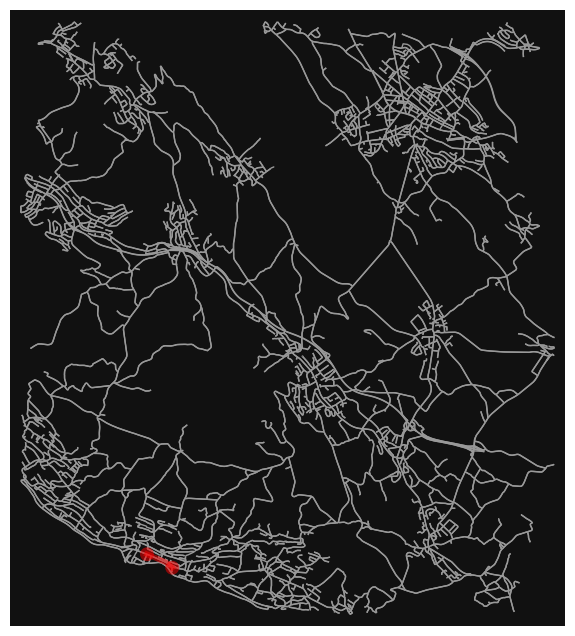

In [10]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [11]:
print(bus_stops)

    id                         name                         geometry
0    1              Meilen, Bahnhof  POINT (2691216.442 1236097.130)
1    2               Meilen, Beugen  POINT (2691721.577 1235859.957)
2    3            Meilen, Schulhaus  POINT (2692164.131 1235952.189)
3    4             Meilen, Aebleten  POINT (2692625.713 1236089.963)
4    5     Uetikon am See, Rundiweg  POINT (2693795.522 1236390.838)
5    6     Uetikon am See, Bergheim  POINT (2694359.533 1236444.631)
6    7         Egg, Ausser-Vollikon  POINT (2695191.913 1237693.175)
7    8          Egg, Inner-Vollikon  POINT (2694957.869 1238374.380)
8    9             Egg, Rainstrasse  POINT (2694619.737 1239083.099)
9   10               Egg, Forchbahn  POINT (2694600.924 1239702.345)
10  11               Egg, Industrie  POINT (2694763.351 1240053.164)
11  12  Riedikon, Chis/Naturstation  POINT (2696074.245 1242503.350)
12  13               Riedikon, Dorf  POINT (2696196.601 1243162.888)
13  14             Uster, Im Hölzl

In [12]:
crs = bus_stops.crs

print("Das Koordinatensystem des GeoDataFrames ist:", crs)

Das Koordinatensystem des GeoDataFrames ist: EPSG:2056
